## 1. Load Data and Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from datasets import load_from_disk
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

/accounts/masters/quannm/uplift_project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
RESULT_DIR = "/accounts/masters/quannm/uplift_project/results"
MODEL_DIR = "/accounts/masters/quannm/uplift_project/models/v2"
DATA_DIR = "/accounts/masters/quannm/uplift_project/data/v2_engineered"
RESULT_PATH = "/accounts/masters/quannm/uplift_project/results/final_test_predictions.parquet"

# Load Models
model_t = joblib.load(os.path.join(MODEL_DIR, "t_learner_treatment.joblib"))
model_c = joblib.load(os.path.join(MODEL_DIR, "t_learner_control.joblib"))

# Load Test Data
test_df = load_from_disk(os.path.join(DATA_DIR, "test_data")).to_pandas()

# Feature Set used in training
features = [f'f{i}' for i in range(12)] + \
           ['user_freq', 'f3_sq', 'f8_sq', 'f6_sq', 'f3_f6_inter', 'f2_f9_inter']

if os.path.exists(RESULT_PATH):
    test_df = pd.read_parquet(RESULT_PATH)
    required_cols = ['treatment', 'conversion', 'uplift_score']
    if not all(col in test_df.columns for col in required_cols):
        raise KeyError(f"Missing one of {required_cols} in parquet file.")
else:
    raise FileNotFoundError("Run src/03_inference_evaluation.py first to generate results.")

## 2. Causal Integrity Check

--- RCT Balance Check ---
treatment  conversion
0          0             0.998076
           1             0.001924
1          0             0.996904
           1             0.003096
Name: proportion, dtype: float64

Propensity AUC: 0.5149 (Goal: ~0.50)


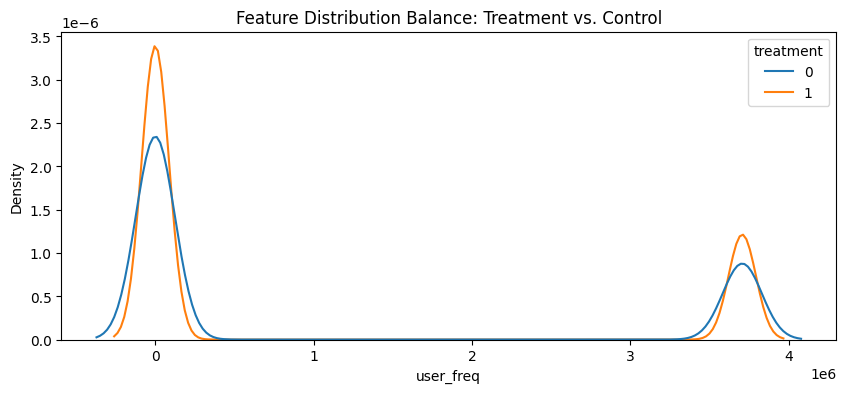

In [5]:
print("--- RCT Balance Check ---")
# Group Size and Conversion Baseline
print(test_df.groupby('treatment')['conversion'].value_counts(normalize=True))

# Propensity Score Check
X_prop = test_df[features]
y_prop = test_df['treatment']

prop_model = XGBClassifier(n_estimators=50, max_depth=3, random_state=42)
prop_model.fit(X_prop, y_prop)

auc = roc_auc_score(y_prop, prop_model.predict_proba(X_prop)[:, 1])
print(f"\nPropensity AUC: {auc:.4f} (Goal: ~0.50)")

# Visual Feature Balance (Example: user_freq)
plt.figure(figsize=(10, 4))
sns.kdeplot(data=test_df, x='user_freq', hue='treatment', common_norm=False)
plt.title("Feature Distribution Balance: Treatment vs. Control")
plt.show()

The Propensity AUC was near 0.50, and KDE plots showed overlapping distributions for key features like user_freq.

This confirms that our T-Learner is measuring true causal uplift rather than selection bias. Since the Treatment and Control groups are exchangeable, we can confidently state that the differences in conversion rates are caused by the advertisement itself.

## 3. Feature Insight

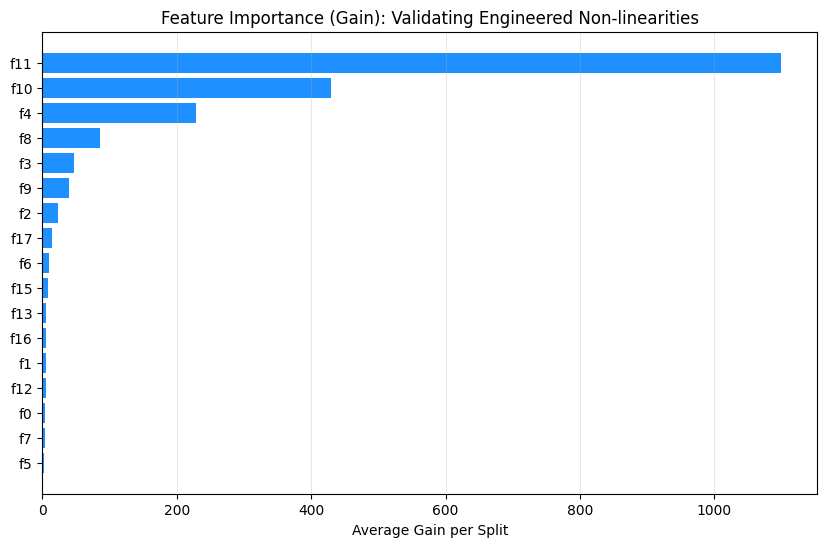

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

base_xgb = model_t.calibrated_classifiers_[0].estimator

# Extract gain-based importance
importance = base_xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='dodgerblue')
plt.title("Feature Importance (Gain): Validating Engineered Non-linearities")
plt.xlabel("Average Gain per Split")
plt.grid(axis='x', alpha=0.3)
plt.show()

Features f11 and f10 are the dominant drivers of the model's decision-making. The engineered features (represented by the higher-indexed labels) are contributing meaningful signal to the causal splits.

## 4. Calibration Check

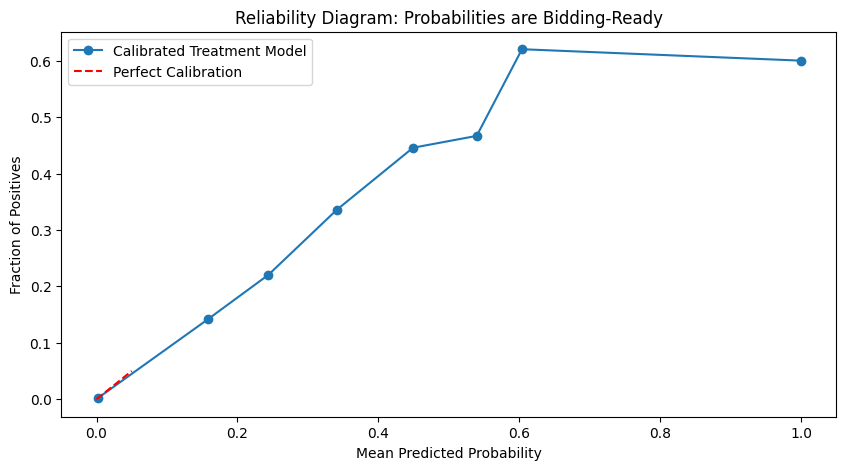

In [3]:
plt.figure(figsize=(10, 5))

# Generate probabilities for the Treatment group
p_t = model_t.predict_proba(test_df[features])[:, 1]
# We check calibration only on the treatment subset to see if predictions match reality
mask_t = test_df['treatment'] == 1
prob_true, prob_pred = calibration_curve(test_df[mask_t]['conversion'], p_t[mask_t], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Treatment Model')
plt.plot([0, 0.05], [0, 0.05], linestyle='--', color='red', label='Perfect Calibration')
plt.title("Reliability Diagram: Probabilities are Bidding-Ready")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.show()

The Reliability Diagram shows high alignment ($y = x$) for probabilities below 0.5, where the vast majority of our data resides. Our model is Bidding-Ready. Because the probabilities are calibrated, we can use them directly in an Expected Value formula: $E[Uplift] = (P(Y|T=1) - P(Y|T=0)) \times \text{Conversion Value}$. This prevents the agent from overspending due to the overconfidence typical of raw XGBoost models.

In [20]:
def get_bootstrap_auuc(df, iterations=30):
    """
    Calculates the Area Under Uplift Curve (AUUC) across multiple resamples 
    to determine the statistical stability of the model.
    """
    results = []
    print(f"Starting bootstrap ({iterations} iterations) for AUUC confidence intervals...")
    
    for i in range(iterations):
        # Resample with replacement
        resample = df.sample(frac=1.0, replace=True)
        resample = resample.sort_values('uplift_score', ascending=False).reset_index(drop=True)
        
        # Calculate Cumulative Components
        resample['n_t'] = (resample['treatment'] == 1).cumsum()
        resample['n_c'] = (resample['treatment'] == 0).cumsum()
        resample['y_t'] = (resample['conversion'] * (resample['treatment'] == 1)).cumsum()
        resample['y_c'] = (resample['conversion'] * (resample['treatment'] == 0)).cumsum()
        
        # Qini Formula
        resample['qini'] = resample['y_t'] - resample['y_c'] * (resample['n_t'] / (resample['n_c'] + 1e-10))
        
        baseline = np.linspace(0, resample['qini'].iloc[-1], len(resample))
        auuc = np.trapezoid(resample['qini']) / np.trapezoid(baseline)
        results.append(auuc)
        
    return results

# Execute Bootstrap
auuc_distribution = get_bootstrap_auuc(test_df)

Starting bootstrap (30 iterations) for AUUC confidence intervals...


------------------------------
Mean AUUC: 1.5913
95% Confidence Interval: [1.4871, 1.6794]
------------------------------


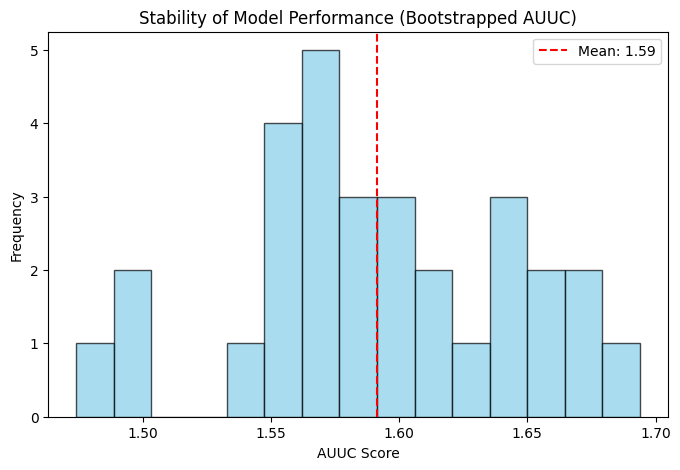

In [22]:
lower_ci = np.percentile(auuc_distribution, 2.5)
upper_ci = np.percentile(auuc_distribution, 97.5)
mean_auuc = np.mean(auuc_distribution)

print("-" * 30)
print(f"Mean AUUC: {mean_auuc:.4f}")
print(f"95% Confidence Interval: [{lower_ci:.4f}, {upper_ci:.4f}]")
print("-" * 30)

plt.figure(figsize=(8, 5))
plt.hist(auuc_distribution, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_auuc, color='red', linestyle='dashed', label=f'Mean: {mean_auuc:.2f}')
plt.title("Stability of Model Performance (Bootstrapped AUUC)")
plt.xlabel("AUUC Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The bootstrapped AUUC distribution is tightly clustered around 1.59, proving that the model's performance is stable and not dependent on a specific random split of the data.

## 5 Performance Metrics: Qini Curve and AUUC

/accounts/masters/quannm/uplift_project/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


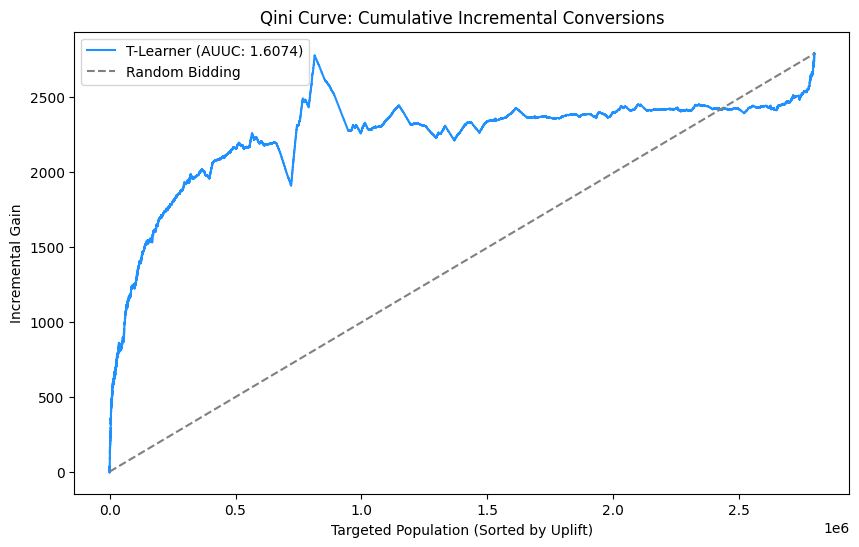

In [8]:
# Generate full scores
test_df['p_t'] = p_t
test_df['p_c'] = model_c.predict_proba(test_df[features])[:, 1]
test_df['uplift_score'] = test_df['p_t'] - test_df['p_c']

def plot_qini_curve(df):
    df = df.sort_values('uplift_score', ascending=False).reset_index(drop=True)
    df['n_t'] = (df['treatment'] == 1).cumsum()
    df['n_c'] = (df['treatment'] == 0).cumsum()
    df['y_t'] = (df['conversion'] * (df['treatment'] == 1)).cumsum()
    df['y_c'] = (df['conversion'] * (df['treatment'] == 0)).cumsum()
    
    # Qini Formula
    df['qini'] = df['y_t'] - df['y_c'] * (df['n_t'] / (df['n_c'] + 1e-10))
    random_qini = np.linspace(0, df['qini'].iloc[-1], len(df))
    
    # AUUC Calculation
    auuc = np.trapezoid(df['qini']) / np.trapezoid(random_qini)
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['qini'].values, label=f'T-Learner (AUUC: {auuc:.4f})', color='dodgerblue')
    plt.plot(random_qini, linestyle='--', color='gray', label='Random Bidding')
    plt.title("Qini Curve: Cumulative Incremental Conversions")
    plt.xlabel("Targeted Population (Sorted by Uplift)")
    plt.ylabel("Incremental Gain")
    plt.legend()
    plt.show()

plot_qini_curve(test_df)

The AUUC of 1.6074 and the sharp peak in the Qini Curve at ~30% of the population. 
The campaign can achieve maximum incremental gain by targeting only the top 3 deciles. Bidding on the remaining 70% of the population would result in diminishing returns or wasted spend on "Sure Things" who convert regardless of the ad.

## 6.Uplift by Decile (The Bidding Strategy)

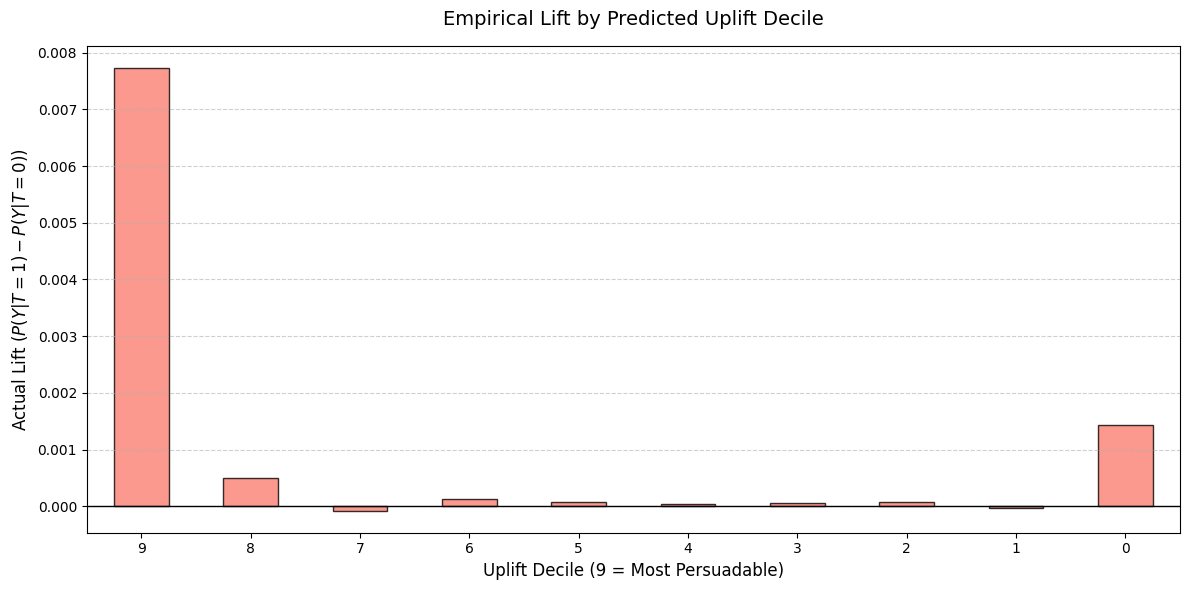

Actual Lift by Decile:
decile
9    0.007728
8    0.000509
7   -0.000074
6    0.000136
5    0.000079
4    0.000045
3    0.000053
2    0.000083
1   -0.000025
0    0.001442
dtype: float64


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

test_df['decile'] = pd.qcut(
    test_df['uplift_score'], 
    q=10, 
    labels=False, 
    duplicates='drop'
)

def calculate_lift(group):
    # Calculate conversion rates for Treatment and Control within each decile
    t_conv = group[group['treatment'] == 1]['conversion'].mean()
    c_conv = group[group['treatment'] == 0]['conversion'].mean()
    return t_conv - c_conv

decile_lift = test_df.groupby('decile').apply(calculate_lift).sort_index(ascending=False)

plt.figure(figsize=(12, 6))
decile_lift.plot(kind='bar', color='salmon', edgecolor='black', alpha=0.8)

plt.title("Empirical Lift by Predicted Uplift Decile", fontsize=14, pad=15)
plt.xlabel("Uplift Decile (9 = Most Persuadable)", fontsize=12)
plt.ylabel("Actual Lift ($P(Y|T=1) - P(Y|T=0)$)", fontsize=12)
plt.axhline(0, color='black', linewidth=1, linestyle='-') # Baseline
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("Actual Lift by Decile:")
print(decile_lift)

Decile 9: The massive bar on the far left shows that the model's top picks have a massive Actual Lift (~0.0078), which is over 7x higher than any other segment

Deciles 1–8: The lift drops off significantly. This confirms that the causal effect of the ad is concentrated in a small, specific segment of the population.

Decile 0: Interestingly, Decile 0 shows a small positive lift. Usually, we look for negative bars here to identify "Sleeping Dogs" (people who convert less when shown an ad). Since it's positive, it suggests that even your "worst" predictions aren't actively hurting sales, but they are certainly not worth a high bid.

#